<h1>Ecological Consumption and its relationship to GDP</h1>

A country’s ecological assets can have a great impact on what it produces in its economy. For example, countries with abundant natural supplies of oil, distribute oil worldwide and it contributes to most of their economic activity. Because of this, we have decided to investigate whether or not the amount of ecological assets a country has impacts their GDP Per Capita. The question we are trying to answer is: Are ecological assets a good predictor of a country’s GDP Per Capita?

The data set we will be using is called “2016 Global Ecological Footprint,” by the Global Footprint Network. This dataset contains information about several countries' ecological footprints, with several observations about their ecological assets such as farmland and urban land. It also has the countries GDP per Capita,  which we will categorize and predict in our model.

In [2]:
# required libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# importing untidy data set
url <- "https://docs.google.com/spreadsheets/d/e/2PACX-1vR_6ci0B-tyn-2T5ywr5cOSxgtls94IPi3zrpu5z3fNxDyK8R1985IH1Uq3zd253ufZIr8Y1tgxffnq/pub?output=csv"

countries_raw_data <- read_csv(url)

#the following steps aim to tidy the data set


#renaming columns to make them syntactically valid

colnames(countries_raw_data) <- tolower(make.names(colnames(countries_raw_data)))

Parsed with column specification:
cols(
  .default = col_double(),
  Country = col_character(),
  Region = col_character(),
  `GDP per Capita` = col_character(),
  `Data Quality` = col_character()
)

See spec(...) for full column specifications.



Here we are selecting the columns that we need from the dataframe. This includes the country's name, GDP per Capita, and the ecological footprints.

In [4]:
countries_GDP_eco <- countries_raw_data %>% select(country, cropland.footprint, 
                                                  grazing.footprint, forest.footprint, 
                                                  fish.footprint, carbon.footprint, gdp.per.capita)

# removing any rows that have an NA cell
countries_GDP_eco <- na.omit(countries_GDP_eco)


# removing the "$" sign and "," from all elements of the gdp.per.capita column
countries_GDP_eco <-  countries_GDP_eco %>% 
                         mutate(gdp.per.capita = gsub("[^[:alnum:][:space:].]", "",
                                                      countries_GDP_eco$gdp.per.capita))

# converting gdp.per.capita from a character data type to double

countries_GDP_eco <- countries_GDP_eco %>% mutate(gdp.per.capita = as.numeric(gdp.per.capita))
countries_GDP_eco

# the following steps are for categorizing the gdp.per.capita column into "High", "Medium", and "low"

# arranging the gdp.per.capita column in an ascending order
countries_GDP_eco <- arrange(countries_GDP_eco, gdp.per.capita)

country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,0.30,0.20,0.08,0.00,0.18,614.66
Albania,0.78,0.22,0.25,0.02,0.87,4534.37
Algeria,0.60,0.16,0.17,0.01,1.14,5430.57
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Yemen,0.34,0.14,0.04,0.04,0.42,1302.30
Zambia,0.19,0.18,0.33,0.01,0.24,1740.64
Zimbabwe,0.20,0.32,0.29,0.01,0.53,865.91


Given that there are about 163 rows, we will categorize the GDP_per_column such that the lowest 40 values (i.e. 1st to 40th row) are assigned to the "low" category, the next 41 values (i.e. 40th to 81st row) are assigned to the "lower middle" category, the next 41 values (i.e. 81st to 122nd row) are assigned to the "upper middle" category, and the remaining rews are assigned to "high" so that each category has roughly (163/4) number of elements.

In [7]:
countries_GDP_eco_classified <- countries_GDP_eco %>% 
    mutate(GDP_classified = cut(countries_GDP_eco$gdp.per.capita,
                                breaks = c(0, 1384.53, 5192.88, 14238.1, Inf),
                                labels = c("low", "lower middle", "upper middle", "high")))

We generate the training and testing data sets using our main data set. A proportion of 75% was dedicated to the training data set, and 25% for the testing data set. This was because our data frame had less than 500 rows.

In [8]:
set.seed(1)
countries_split <- initial_split(countries_GDP_eco_classified, prop = 0.75, strata = GDP_classified)
countries_train <- training(countries_split)
countries_test <- testing(countries_split)



In [9]:
# the following steps give a summary of the data, using only the training set. 

# table showing the distribution between the different categories for the training data
countries_train_categories <- countries_train %>%
    select(GDP_classified) %>%
    group_by(GDP_classified) %>%
    summarise(n = n())

countries_train_categories

# table giving the means of each of the predictors
countries_train_predictors <- countries_train %>%
    select(cropland.footprint, grazing.footprint, forest.footprint, fish.footprint, carbon.footprint)

mean_of_predictors <- map_df(countries_train_predictors, mean)

mean_of_predictors

`summarise()` ungrouping output (override with `.groups` argument)



GDP_classified,n
<fct>,<int>
low,30
lower middle,31
upper middle,31
high,31


cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5837398,0.2373171,0.3822764,0.1276423,1.814146


We want to create the recipe for our algorithm. We also want to perform a cross-validation because we want to find the most optimal $k$ value for our k-nn classification. We then want to collect the metrics from the workflow analysis.

In [10]:
set.seed(1)
#creating our recipe
countries_recipe <- recipe(GDP_classified ~ cropland.footprint + grazing.footprint + forest.footprint + 
                           fish.footprint + carbon.footprint, data = countries_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

#specifications for our model
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

#cross-validation
countries_vfold <- vfold_cv(countries_train, v = 5, strata = GDP_classified)

grid_vals <- tibble(neighbors = seq(1, 30))

#workflow analysis metrics
countries_results <- workflow() %>%
    add_recipe(countries_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = countries_vfold, grid = grid_vals) %>%
    collect_metrics()

countries_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.4796296,5,0.03090429,Model01
1,roc_auc,hand_till,0.6539683,5,0.02063492,Model01
2,accuracy,multiclass,0.4796296,5,0.03090429,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,roc_auc,hand_till,0.7969860,5,0.01165516,Model29
30,accuracy,multiclass,0.5611111,5,0.02087958,Model30
30,roc_auc,hand_till,0.8043509,5,0.01321726,Model30


The metrics are now used in order to graph out the $k$ value vs the Accuracy Estimate. We use this graph to find the best $k$ value for our dataset.

[1] 20

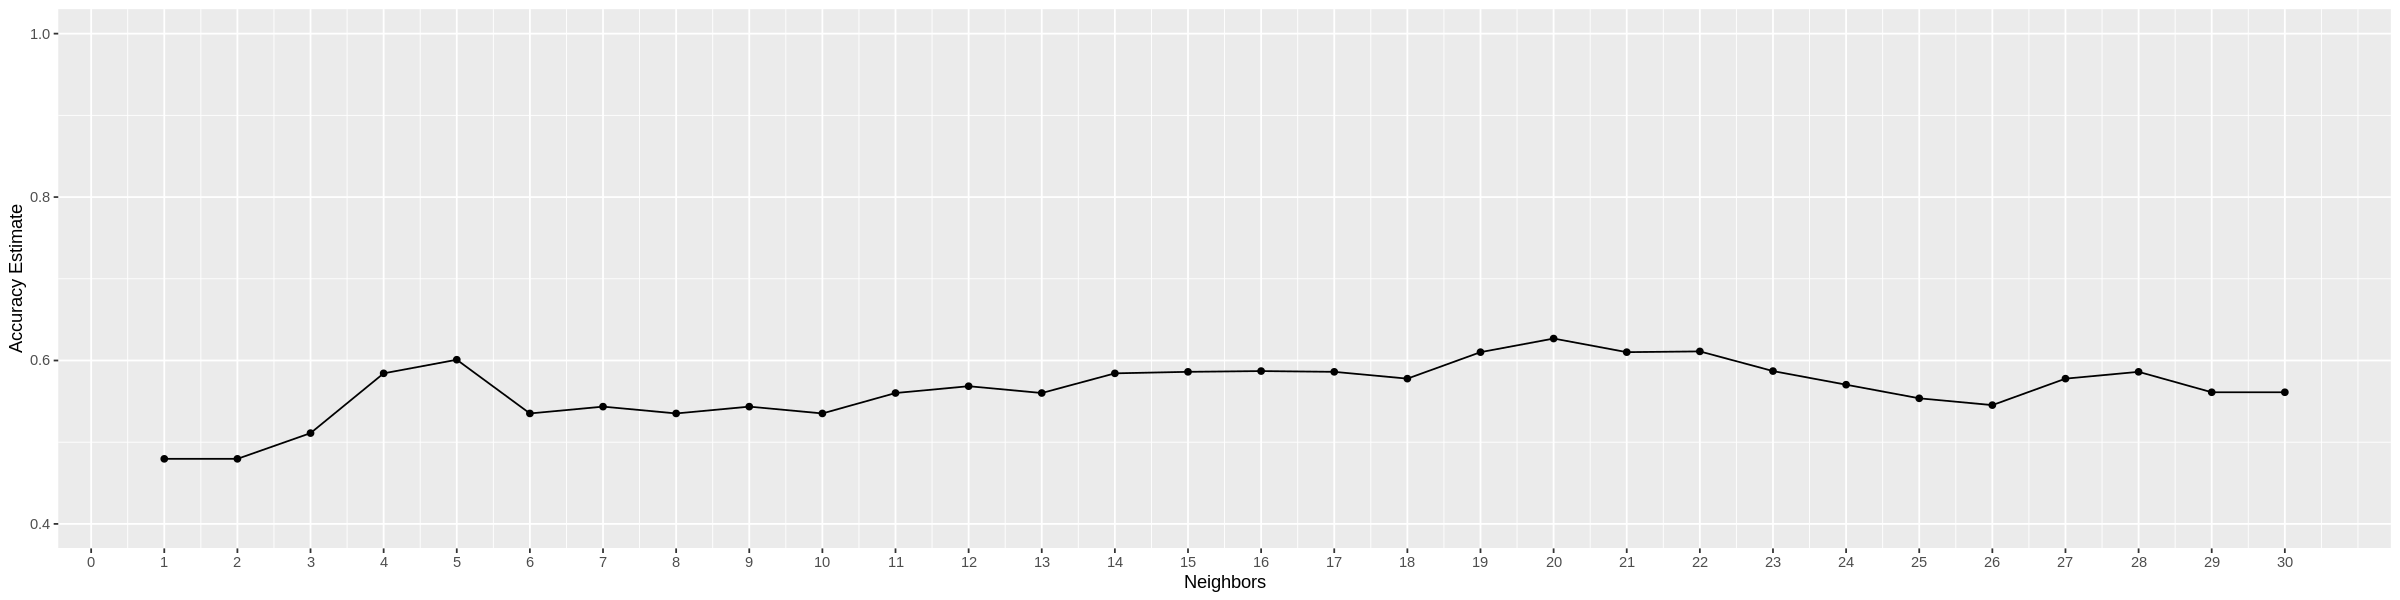

In [11]:
#filtering out the metrics to only display accuracy
accuracies <- countries_results %>% 
      filter(.metric == "accuracy")

#plotting out the k vs accuracy estimate in order to visualize the relationship between them.
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 30, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0))

cross_val_plot


#finding the k value with the highest accuracy
kmax <- accuracies %>%
    filter(mean == max(mean)) %>%
    pull(neighbors)

kmax

From the graph above we can choose the best $k$ value for our specifications. We will choose the $k$ = 20 value because it seems to be the most accurate and it most likely will not over-fit or under-fit.

In [12]:
set.seed(2) 

# creating new knn specification using the k value we got from the graph
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = kmax) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# creating the fit using the training data
countries_fit <- workflow() %>%
      add_recipe(countries_recipe) %>%
      add_model(knn_spec) %>%
      fit(data = countries_train)

In [13]:
set.seed(2) 

# predicting the GDP_classified of the test data
countries_predictions <- predict(countries_fit, countries_test) %>%
    bind_cols(countries_test)

countries_predictions

# finding the accuracy of the prediction
countries_metrics <- countries_predictions %>%
    metrics(truth = GDP_classified, estimate = .pred_class)

countries_metrics

# finding the confusion matrix of the prediction
countries_conf_mat <- countries_predictions %>%
    conf_mat(truth = GDP_classified, estimate = .pred_class)

countries_conf_mat

.pred_class,country,cropland.footprint,grazing.footprint,forest.footprint,fish.footprint,carbon.footprint,gdp.per.capita,GDP_classified
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
low,Madagascar,0.27,0.34,0.24,0.02,0.07,456.33,low
low,Malawi,0.43,0.05,0.20,0.01,0.07,493.84,low
low,Central African Republic,0.30,0.55,0.26,0.02,0.08,495.04,low
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
high,Singapore,0.67,0.24,0.91,0.22,5.91,53122.4,high
high,Australia,2.68,0.63,0.89,0.11,4.85,66604.2,high
high,Switzerland,0.75,0.22,0.38,0.07,4.26,88506.2,high


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6000000
kap,multiclass,0.4666667


              Truth
Prediction     low lower middle upper middle high
  low           10            6            1    0
  lower middle   0            2            2    0
  upper middle   0            2            4    2
  high           0            0            3    8

We can see that even with the most optimal $k$ value, we still have a very low accuracy. The algorithm seems to struggle the most with distinguishing between the lower middle and the low categories. This might be because both of them are very similar.

In [14]:
prediction_long <- pivot_longer(countries_predictions,
  cols = cropland.footprint:carbon.footprint,
  names_to = "footprint.name",
  values_to = "footprint.value"
)
prediction_long

.pred_class,country,gdp.per.capita,GDP_classified,footprint.name,footprint.value
<fct>,<chr>,<dbl>,<fct>,<chr>,<dbl>
low,Madagascar,456.33,low,cropland.footprint,0.27
low,Madagascar,456.33,low,grazing.footprint,0.34
low,Madagascar,456.33,low,forest.footprint,0.24
⋮,⋮,⋮,⋮,⋮,⋮
high,Switzerland,88506.2,high,forest.footprint,0.38
high,Switzerland,88506.2,high,fish.footprint,0.07
high,Switzerland,88506.2,high,carbon.footprint,4.26


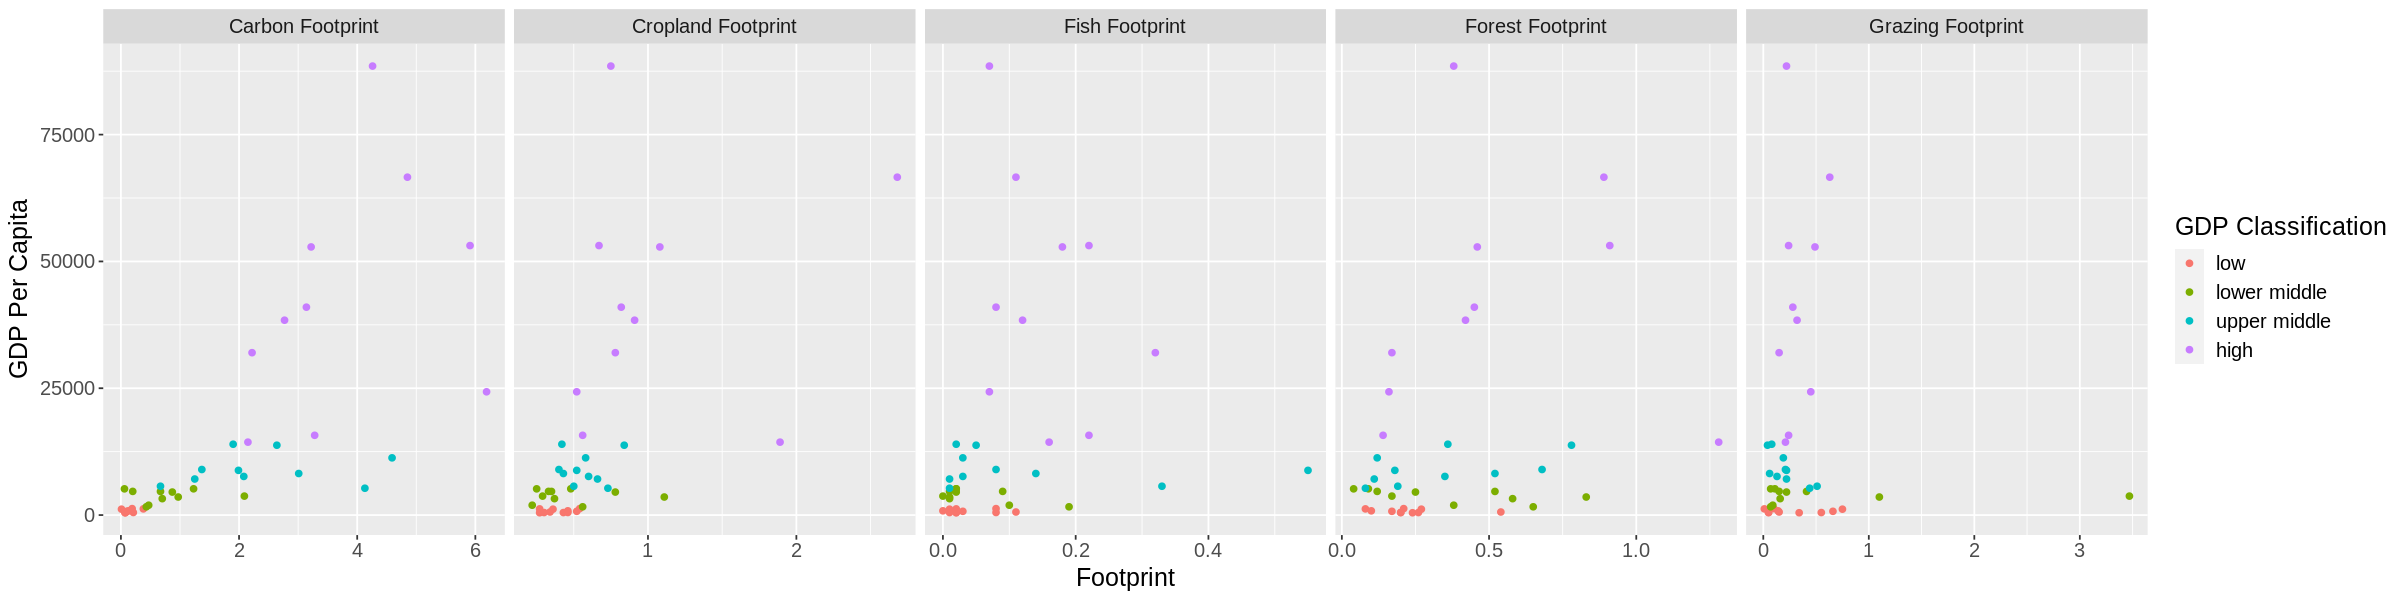

In [15]:
options(repr.plot.width = 20, repr.plot.height = 5)

footprint_labels <- c(carbon.footprint = "Carbon Footprint",
                      cropland.footprint = "Cropland Footprint",
                      fish.footprint = "Fish Footprint",
                      forest.footprint = "Forest Footprint",
                      grazing.footprint = "Grazing Footprint")

footprint_gdp_graphs <- prediction_long %>%
   ggplot(aes(x = footprint.value, y = gdp.per.capita)) +
   geom_point(aes(colour = GDP_classified)) +
   labs(x = "Footprint", y = "GDP Per Capita", colour = "GDP Classification") +
   facet_grid(~ footprint.name,
              scales = "free",
              labeller = labeller(footprint.name = footprint_labels)) +
   theme(text = element_text(size=15))

footprint_gdp_graphs